## 12-1. 프로젝트: 한영 번역기 만들기

In [28]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


## Step 1. 데이터 다운로드

korean-english-park.train.tar.gz 다운로드


In [4]:
! wget https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2024-07-09 07:08:17--  https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘korean-english-park.train.tar.gz’

korean-english-park     [ <=>                ] 164.02K  --.-KB/s    in 0.03s   

2024-07-09 07:08:18 (5.95 MB/s) - ‘korean-english-park.train.tar.gz’ saved [167959]



In [29]:
# 프로젝트에 사용될 라이브러리 import
import tensorflow as tf
import numpy as np

import matplotlib.ticker as ticker

import time
import re
import os
import io

import pandas as pd
import urllib.request
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

print(tf.__version__)

2.6.0


In [30]:

path_to_file = os.getenv('HOME')+'/aiffel/workplace/20240709/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw_ko = f.read().splitlines()

path_to_file = os.getenv('HOME')+'/aiffel/workplace/20240709/korean-english-park.train.en'

with open(path_to_file, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size:", len(raw_ko))
print("Data Size:", len(raw_en))

print("Example:")
for sen_ko, sen_en in zip(raw_ko[0:100][::20], raw_en[0:100][::20]): 
    print(">>", sen_ko, sen_en)
     

Data Size: 94123
Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?" Much of personal computing is about "can you top this?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다. Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다." “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다. Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다. Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the ki

## Step 2. 데이터 정제

s1. et 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.
    

In [31]:

pallel_corpus = list(set(zip(raw_ko,raw_en)))
print(len(pallel_corpus))

pallel_corpus = pallel_corpus[:30000]

cleaned_corpus_ko = []
cleaned_corpus_en =[]

for i in range(len(pallel_corpus)):
    cleaned_corpus_ko.append(pallel_corpus[i][0])
    
for i in range(len(pallel_corpus)):
    cleaned_corpus_en.append(pallel_corpus[i][1])

for sen_ko,sen_en in zip(cleaned_corpus_ko[:100:20],cleaned_corpus_en[:100:20]): 
    print(">>", sen_ko ,sen_en)   

78968
>> 미국에서는 대중교통 수단 부족으로 많은 미국인들이 출퇴근 때 자동차를 몰고 장거리 운행을 한다. 이들이 소비하는 휘발유는 관찰의 대상이다. Also, since Americans are particularly reliant on their cars dues to a lack of mass transport in all but a few cities and they have to drive longer distances to their jobs, their consumption of gasoline is closely watched.
>> IMF는 세계 성장이 2008년 실질적으로 둔화될 예정이며 완만한 회복세는 내년 말에나 시작될 것이라고 말했다. Global growth was projected to slow substantially in 2008, and a modest recovery would only begin later in 2009, it said.
>> 정치권과 군 지도자들은 시아파 성지 신전에 대한 폭탄공격 이후 촉발된 폭력사태를 진정시키기 위한 회의에서 진척을 이루었다고 말했었다. Political and militia leaders say they have made progress in talks to curb the violence that was sparked by the bombing of a major Shiite shrine.
>> 머지사이드 경찰 대변인 캐롤라인 포란씨는 ''이 밴을 과학적 방법으로 조사하고 있으며 목격자를 찾고 있다’’고 말했다. ``The van is being forensically examined, and we are appealing for witnesses,'' said Caroline Foran, a spokeswoman for Merseyside police.
>> 미셸 김은 “이 공연으로 북한과 미국간에 정치적인 문제가 해결될 수는 없다”며 “그러나 이번 공연이 그들의 기억 속에 남

In [69]:
from konlpy.tag import Mecab
tokenizer = Mecab()

# 전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주기
#  Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")


def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    sentence = tokenizer.morphs(sentence)
    
    return sentence

def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split()
    
    return sentence

슝~


In [70]:

max_len = 40

enc_corpus = []
dec_corpus = []

for sen_ko, sen_en in zip(cleaned_corpus_ko, cleaned_corpus_en):
    if len(sen_ko) <= max_len:
        enc_corpus.append(preprocess_sentence_ko(sen_ko))
        dec_corpus.append(preprocess_sentence_en(sen_en, s_token=True, e_token=True))

print("Korean:", enc_corpus[99])  
print("English:", dec_corpus[99])  

Korean: ['wtvm', 'tv', '에서', '제공', '한', '내용', '입니다', '.']
English: ['<start>', 'that', 'came', 'from', 'wtvm', 'tv', '.', '<end>']


## Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [71]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [72]:

# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train = enc_tensor
dec_train = dec_tensor

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 10366
English Vocab Size: 10591


In [73]:
print(enc_tensor[10])
print(dec_tensor[10])

[467 664  48  29  51  15  29   7 194  12 801  16 294   9   2   1   0   0
   0   0   0   0   0   0]
[   1   41   86    7  168 3404  834 1727 2072   15   41    5  835    3
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


## Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [74]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [75]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # TODO: Awesome Encoder Modules        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        # TODO: Awesome Process
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [76]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        # TODO: Awesome Decoder Modules
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        # Attention 필수 사용!
        self.attention = BahdanauAttention(self.dec_units) 

    def call(self, x, h_dec, enc_out):
        # TODO: Awesome Process
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [77]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 10592)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


## Step 5. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

In [78]:
# Optimizer와 Loss 구현하기
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [79]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [80]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm


Epoch 10: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s, Loss 0.7829]


In [88]:
# 평가하기
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([str(sentence).split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(str(result).split()), :len(str(sentence).split())]
    plot_attention(attention, str(sentence).split(), str(result).split(' '))

## 예문 및 제출 ##
* K1) 오바마는 대통령이다.  
* E1) obama is the president . <end>
    

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: he was arrested on the future . <end> 


/tmp/ipykernel_35/2478184123.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_35/2478184123.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


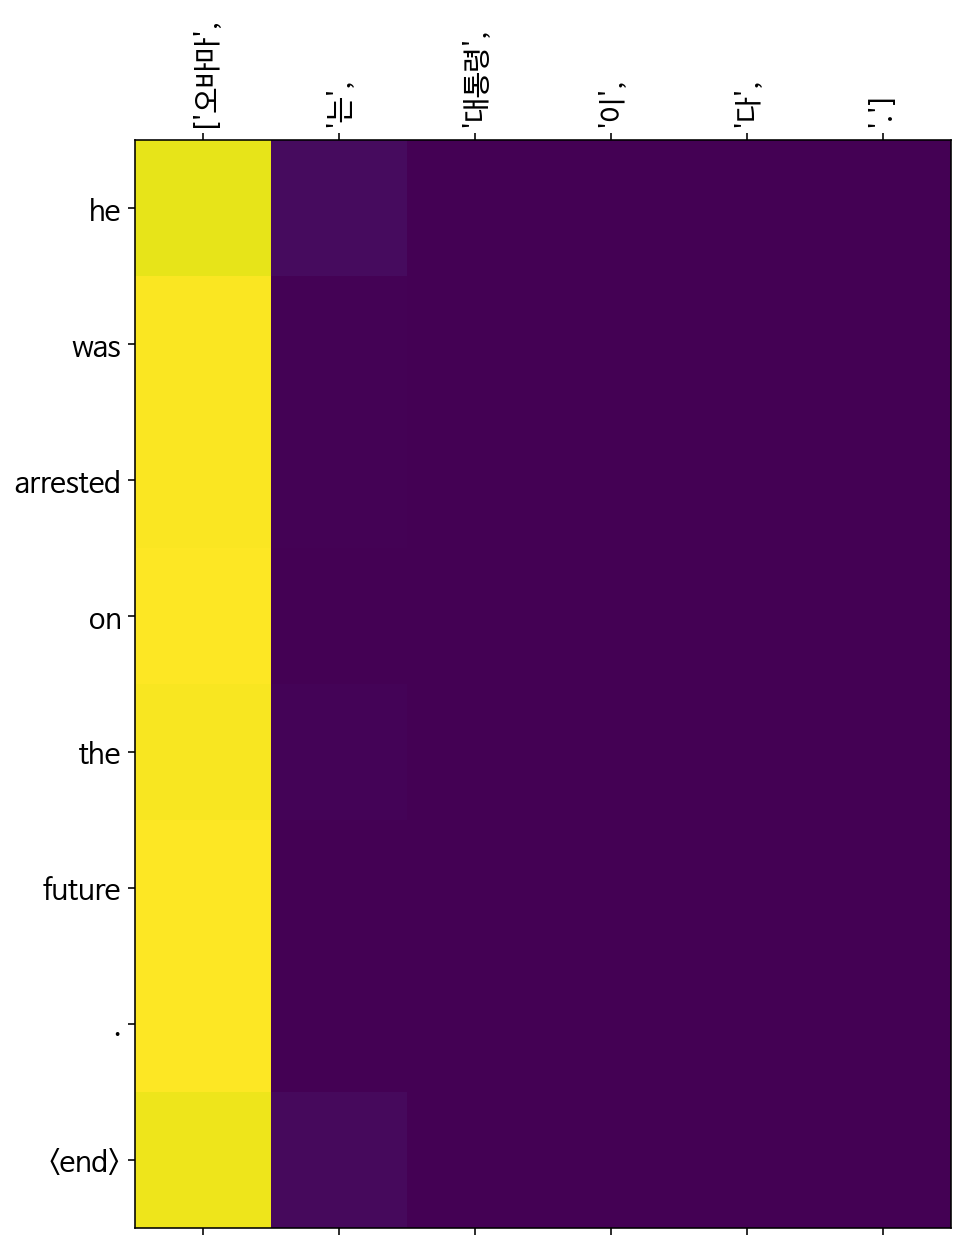

In [89]:
translate('오바마는 대통령이다.', encoder, decoder)

* K2) 시민들은 도시 속에 산다.
* E2) people are victims of the city . <end>

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: he was arrested on the future . <end> 


/tmp/ipykernel_35/2478184123.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_35/2478184123.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


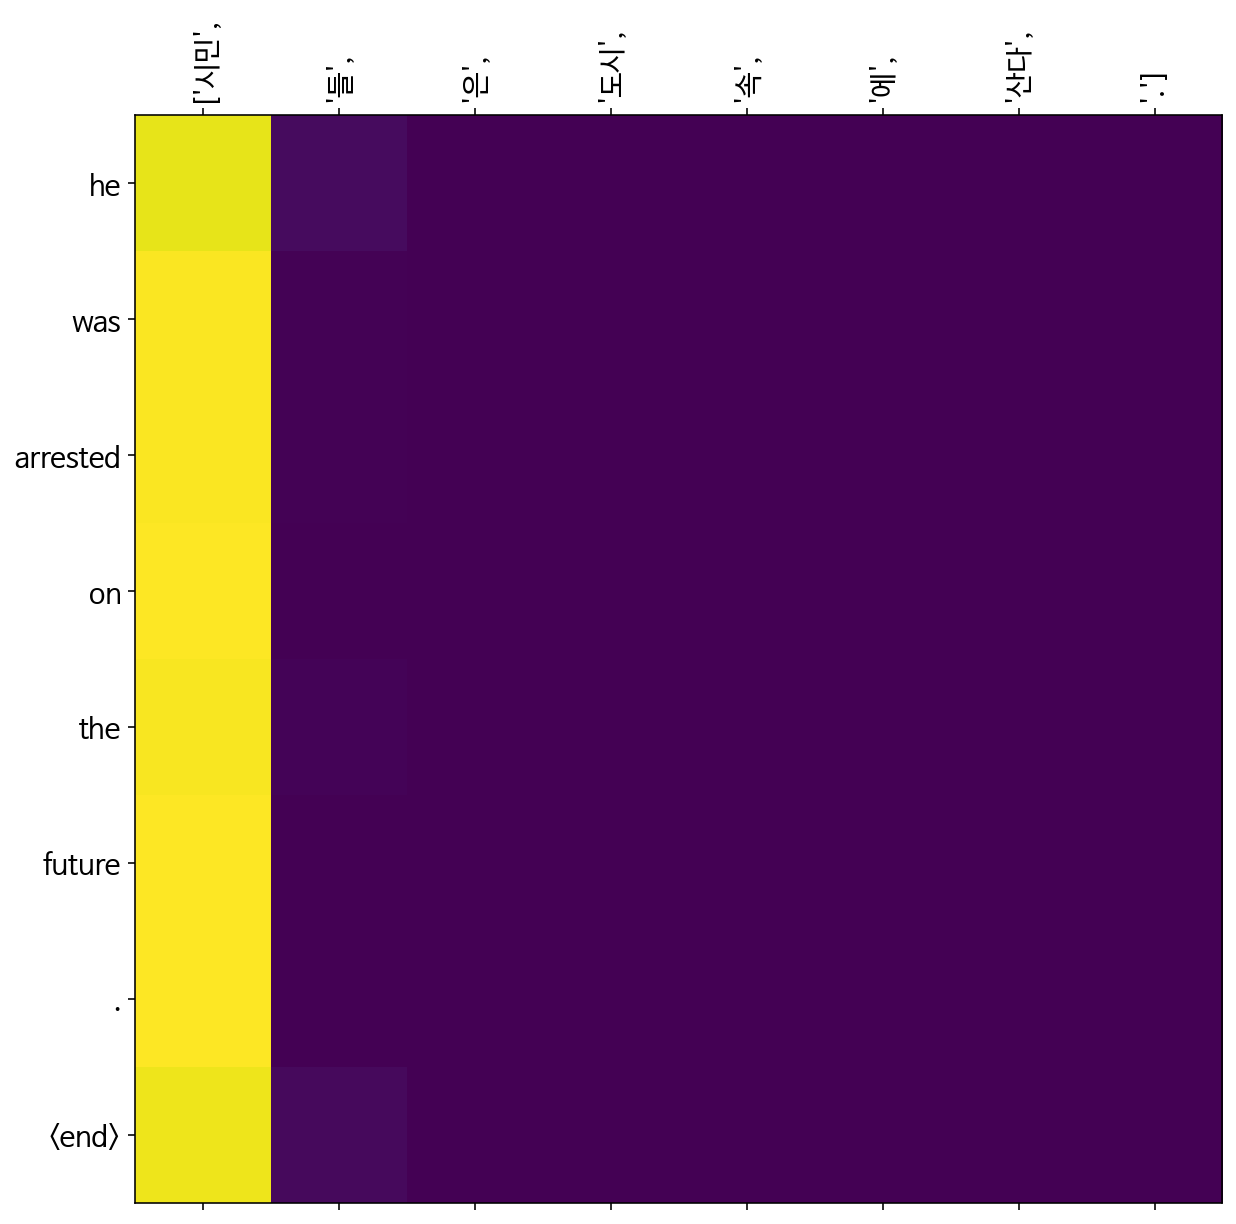

In [96]:


translate("시민들은 도시 속에 산다.", encoder, decoder)
     
  

* K3) 커피는 필요 없다.
* E2) the price is not enough . <end>    


Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: he was arrested on the future . <end> 


/tmp/ipykernel_35/2478184123.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_35/2478184123.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


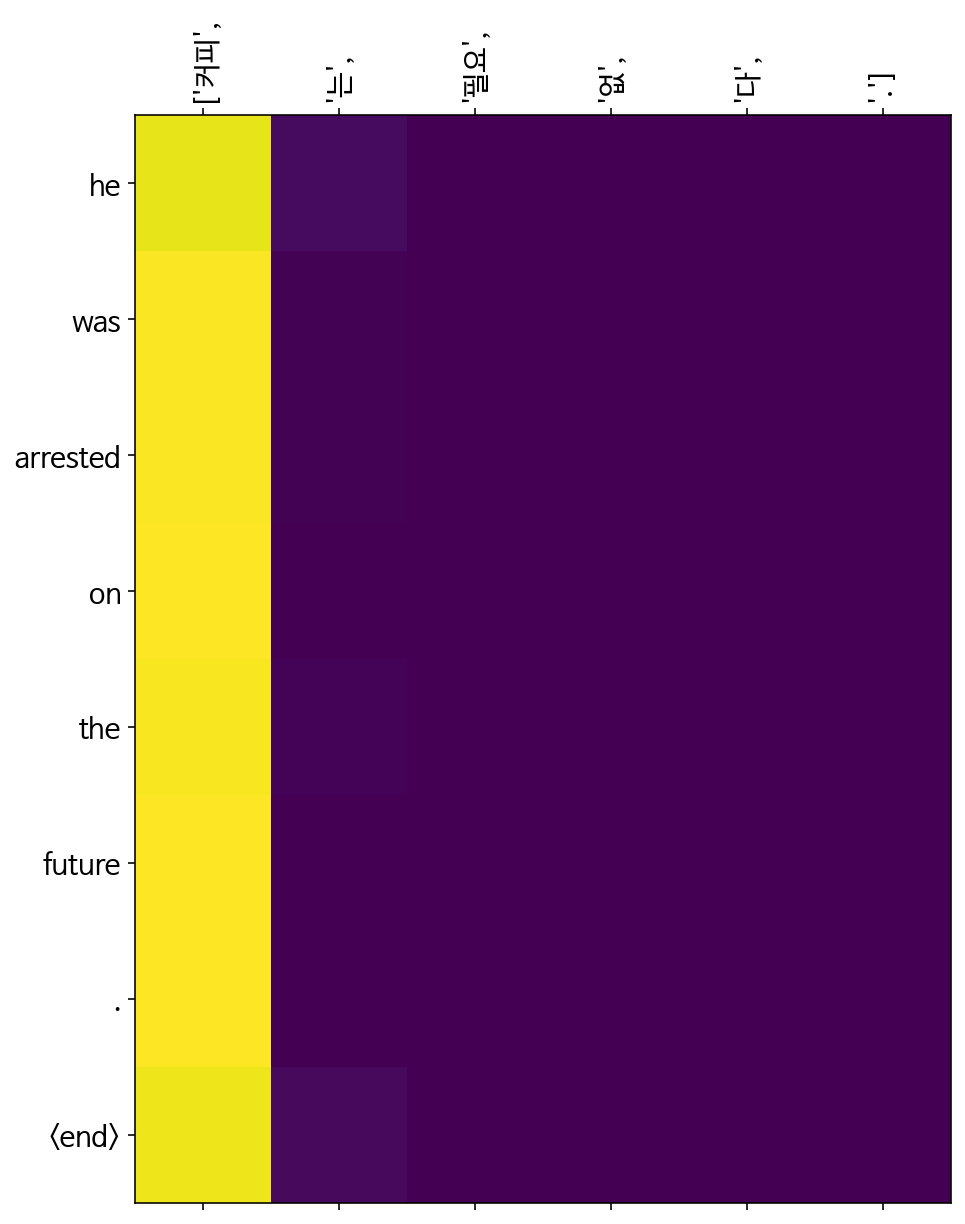

In [97]:

translate("커피는 필요 없다.", encoder, decoder)

* K4) 일곱 명의 사망자가 발생했다.
* E2) seven people have died . <end>

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: he was arrested on the future . <end> 


/tmp/ipykernel_35/2478184123.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_35/2478184123.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


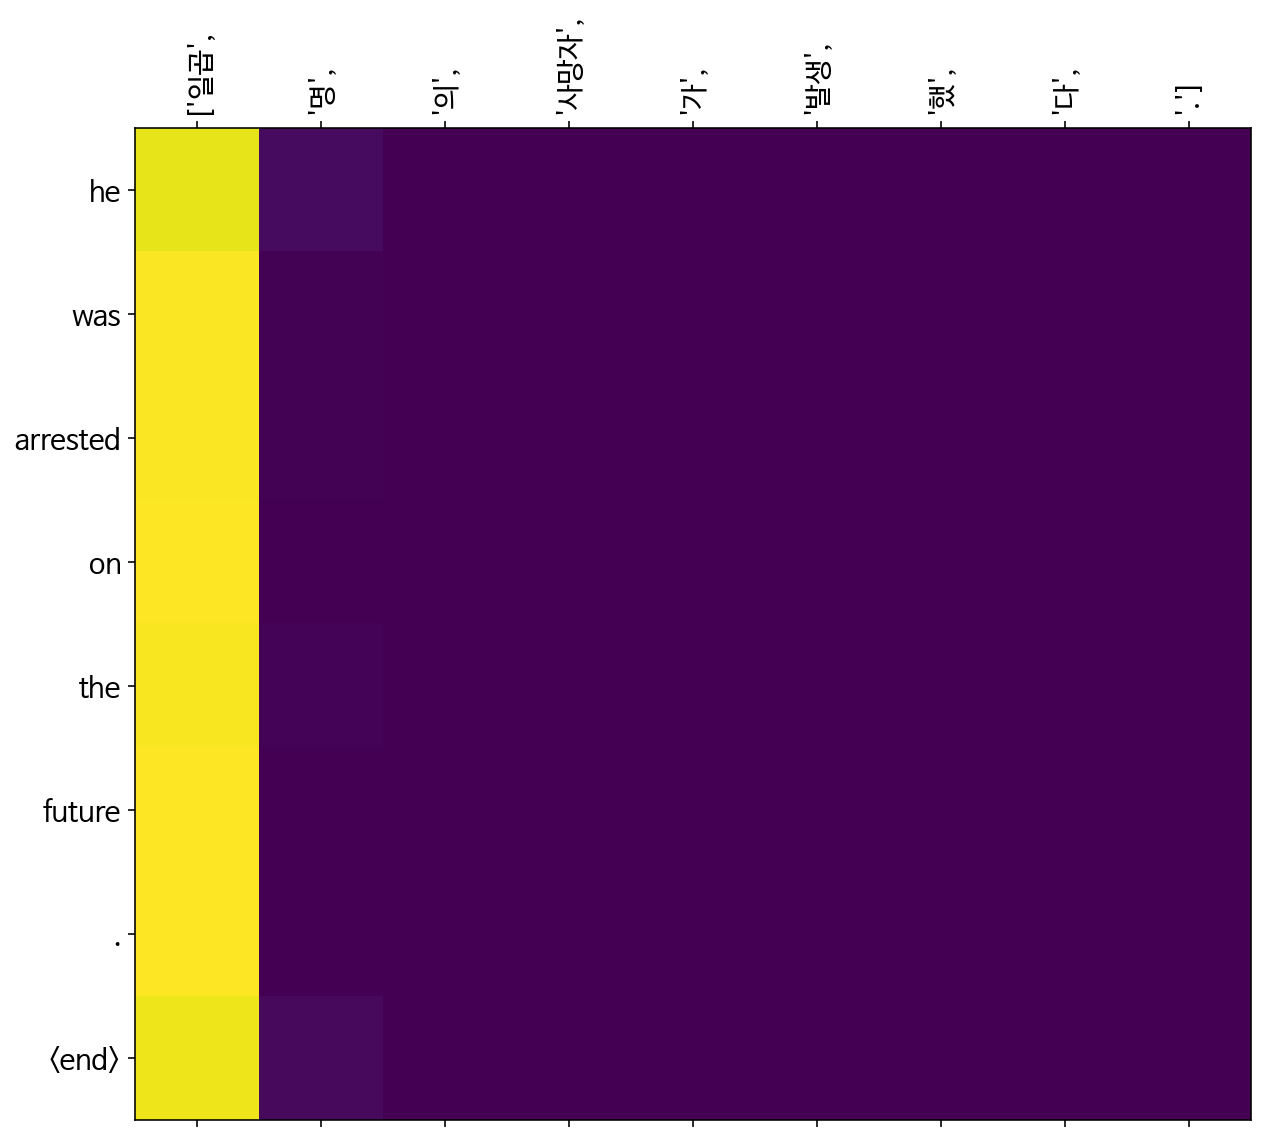

In [93]:
translate('일곱 명의 사망자가 발생했다.', encoder, decoder)


-  **4. 프로젝트에 대한 회고가 상세히 기록 되어 있나요? (회고, 정리)**
    - 배운 점 :  seq2seq , attention, transformer? 등등 번역의 여러가지 nlp 모델
    - 아쉬운 점 : 논문이나 블로그를 꼼꼼하게 읽지 못했다...
    - 느낀 점 : 힘들었다... 성능이 왜이렇게 안나오지? 데이터 의 양의 부족인가? train 의 문제인가? 이상하다 이상해~!
    - 어려웠던 점 : 힘들었다... 성능이 왜이렇게 안나오지?


